In [61]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
from tensorflow.keras.models import *
from tensorflow.keras.layers import *

In [62]:
train = pd.read_csv('fashion-mnist_train.csv')
train = train.drop(['label'],axis=1).to_numpy().reshape(-1,28,28,1)

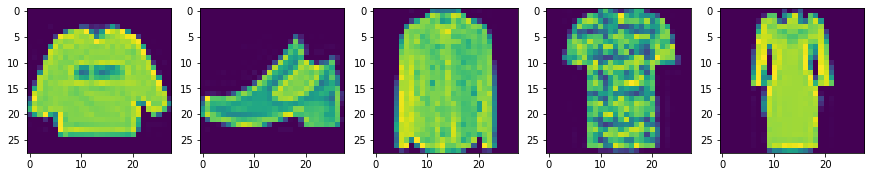

In [63]:
fig,axes = plt.subplots(1,5,figsize=(15,15))
for index,x in enumerate(train[:5]):
    axes[index].imshow(x)

In [64]:
def preprocess(records):
    images =  records['image']
    images = tf.cast(images, tf.float32)/255.0
    return images

dataset = tf.data.Dataset.from_tensor_slices({'image':train})
dataset = dataset.map(preprocess)
dataset = dataset.repeat(3).shuffle(100).batch(128).prefetch(1)

In [65]:
print(dataset)

<PrefetchDataset shapes: (None, 28, 28, 1), types: tf.float32>


In [66]:
input_shape = (28,28,1)
final_encoder_dim = 2
decoder_input_dim = 4
depth = 5
kernel_size = 3
activation = 'tanh'
dropout = 0.1

In [67]:

def discriminator(input_shape, dim, depth, kernel, dropout,activation):
    layers = []
    layers.append(InputLayer(input_shape=input_shape))
    for i in range(1,depth):
        layers.append(Conv2D(16*i,kernel_size=kernel_size))
        layers.append(BatchNormalization())
        layers.append(Activation('relu'))
        layers.append(Dropout(dropout))
    layers.append(Flatten())
    layers.append(Dense(128,activation='relu'))
    layers.append(Dense(dim))
    return Sequential(layers)

encoder = discriminator(input_shape, final_encoder_dim, depth, kernel_size, dropout,activation)

In [68]:
encoder.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 26, 26, 16)        160       
_________________________________________________________________
batch_normalization_20 (Batc (None, 26, 26, 16)        64        
_________________________________________________________________
activation_20 (Activation)   (None, 26, 26, 16)        0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 26, 26, 16)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 24, 24, 32)        4640      
_________________________________________________________________
batch_normalization_21 (Batc (None, 24, 24, 32)        128       
_________________________________________________________________
activation_21 (Activation)   (None, 24, 24, 32)       

In [69]:
def generator(input_shape, depth, output_shape,kernel,dropout):
    layers = []
    layers.append(InputLayer(input_shape=(input_shape,)))
    layers.append(Dense(784,activation='relu'))
    layers.append(Reshape(target_shape=output_shape))
    for i in range(1,depth):
        layers.append(Conv2DTranspose(16*i,kernel_size=kernel))
        layers.append(BatchNormalization())
        layers.append(Activation('relu'))
        layers.append(Dropout(dropout))
    
    resizer =  lambda name: Lambda(lambda images: tf.image.resize(images, [28,28]), name=name)
    layers.append(resizer('Reshape'))
    layers.append(Conv2DTranspose(1,kernel_size=1,activation=None))
    return Sequential(layers)
decoder = generator(decoder_input_dim, depth, input_shape,kernel_size,dropout)

In [70]:
decoder.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 784)               3920      
_________________________________________________________________
reshape_2 (Reshape)          (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_transpose_10 (Conv2DT (None, 30, 30, 16)        160       
_________________________________________________________________
batch_normalization_24 (Batc (None, 30, 30, 16)        64        
_________________________________________________________________
activation_24 (Activation)   (None, 30, 30, 16)        0         
_________________________________________________________________
dropout_24 (Dropout)         (None, 30, 30, 16)        0         
_________________________________________________________________
conv2d_transpose_11 (Conv2DT (None, 32, 32, 32)       

In [71]:
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)
encoder_opt = tf.keras.optimizers.Adam()
decoder_opt = tf.keras.optimizers.Adam()

In [72]:

def training(training_data):
    batch_size = tf.shape(training_data)[0]
    real_data = training_data
    real_labels = tf.ones((batch_size,))
    fake_labels = tf.zeros((batch_size,))
    labels = tf.concat((real_labels,fake_labels),axis=0)
    noise = tf.random.normal((batch_size,decoder_input_dim),mean=0,stddev=1)
    
    with tf.GradientTape() as decoder_gt, tf.GradientTape() as encoder_gt:
        
        fake_images = decoder(noise,training=True)
        fake_labels_2 = encoder(fake_images,training=True)
        real_labels_2 = encoder(training_data,training=True)
        predicted_labels = tf.concat((real_labels_2,fake_labels_2),axis=0)
        

        discrim_loss = loss(labels,predicted_labels)
        #print(discrim_loss)
        gen_loss = loss(real_labels,fake_labels_2)
        
    dec_grad = decoder_gt.gradient(gen_loss,decoder.trainable_variables)
    enc_grad = encoder_gt.gradient(discrim_loss,encoder.trainable_variables)
    
    decoder_opt.apply_gradients(zip(dec_grad, decoder.trainable_variables))
    encoder_opt.apply_gradients(zip(enc_grad, encoder.trainable_variables))
    
    return discrim_loss, gen_loss

In [83]:
import os
def epoch_training(data_iterator, steps_per_epoch, avg_gen_loss, avg_dis_loss):
    for x in range(steps_per_epoch):
        d_loss, g_loss = training(next(data_iterator))
        avg_gen_loss.update_state(g_loss)
        avg_dis_loss.update_state(d_loss)
        if x%20==0:
            print('{} steps done'.format(x))
            
    gen_loss = avg_gen_loss.result()
    dis_loss = avg_dis_loss.result()
    
    
    tf.summary.scalar('gen_loss',gen_loss,step=encoder_opt.iterations)
    tf.summary.flush()
    tf.summary.scalar('dis_loss',dis_loss,step=decoder_opt.iterations)
    tf.summary.flush()
    
    avg_gen_loss.reset_state()
    avg_dis_loss.reset_state()
    return gen_loss.numpy(), dis_loss.numpy()
    
def train(training_data, epochs):
    checkpoint_dir = './training_checkpoints'
    checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
    checkpoint = tf.train.Checkpoint(generator_optimizer=decoder_opt,discriminator_optimizer=encoder_opt,generator=decoder,discriminator=encoder)
    manager = tf.train.CheckpointManager(checkpoint, 'training_checkpoints', max_to_keep=5)
    checkpoint.restore(manager.latest_checkpoint)
    
    summary = tf.summary.create_file_writer('metrics/train')
    
    avg_generator_loss = tf.keras.metrics.Mean()
    avg_discriminator_loss = tf.keras.metrics.Mean()
    
    data_iterator = training_data.__iter__()
    for i in range(epochs):
        with summary.as_default():
            gen_loss, dis_loss = epoch_training(data_iterator, 100, avg_generator_loss, avg_discriminator_loss)
            print({'gen_loss':gen_loss,'dis_loss':dis_loss})
            manager.save()


In [84]:
train(dataset,100)

0 steps done
20 steps done
40 steps done
60 steps done
80 steps done
{'gen_loss': 7.3140626, 'dis_loss': 0.07812591}
0 steps done
20 steps done
40 steps done
60 steps done
80 steps done
{'gen_loss': 6.7936645, 'dis_loss': 0.10283947}
0 steps done
20 steps done
40 steps done
60 steps done
80 steps done
{'gen_loss': 7.0724363, 'dis_loss': 0.07900731}
0 steps done
20 steps done
40 steps done
60 steps done
80 steps done
{'gen_loss': 7.0484147, 'dis_loss': 0.07341627}
0 steps done


KeyboardInterrupt: 

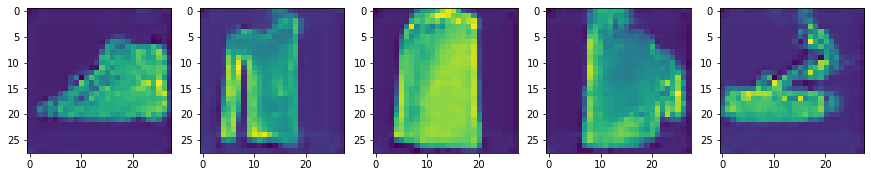

In [86]:
noise = tf.random.normal((5,4),mean=0,stddev=1)
images = decoder(noise,training=False)
fig,axes = plt.subplots(1,5,figsize=(15,15))
for index,x in enumerate(images):
    axes[index].imshow(x)

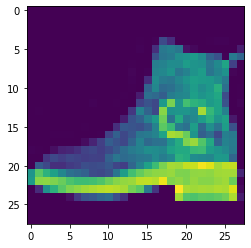

In [20]:
count =0
for x in dataset:
    
    plt.imshow(x[1])
    if count==5:
        break
    count+=1

In [ ]:
import tensorflow as tf

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint